<a href="https://colab.research.google.com/github/Schiessl/AgoraVAI/blob/main/Compara_CDI_e_Ativos_%2B_Dividendos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importando Bibliotecas

In [10]:
import importlib

# verificar se o pacote yfinance está instalado
try:
    importlib.import_module('yfinance')
except ImportError:
    # se o pacote não estiver instalado, instalá-lo com o alias yf
    !pip install yfinance --upgrade --no-cache-dir
    importlib.import_module('yfinance as yf')
else:
    import yfinance as yf

import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

from typing import Optional
import datetime
from datetime import date, datetime, timedelta
import time
# import seaborn as sns
# Handle date time conversions between pandas and matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
# import matplotlib
plt.rcParams['figure.figsize'] = (16,8)


# Funções para execução dos procedimentos

## Download via API do Banco Central do Brasil

http://api.bcb.gov.br/dados/serie/bcdata.sgs.432/dados?formato=json 

URL da api - basta mudar o número para acessar a série

https://www3.bcb.gov.br/sgspub/localizarseries/localizarSeries.do?method=prepararTelaLocalizarSeries

Link principal das séries disponíveis no BC

In [11]:
def consulta_bc(codigo_bcb, data_inicio):
  url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json'.format(codigo_bcb)
  df = pd.read_json(url)
  df['data'] = pd.to_datetime(df['data'], dayfirst=True)
  df = df[df['data'] >= data_inicio]
  df.set_index('data', inplace=True)
  return df

## Define datas

In [12]:
# Define período para consulta
def define_periodo(anos):
  dias_dif = 365.2*anos
  today = date.today()
  data_hoje = today.strftime("%d/%m/%Y") # data de hoje em formato brasileiro
  date_today = today.strftime("%Y-%m-%d")  # data de hoje em formato brasileiro
  inicio = datetime.now() + timedelta(days=(-dias_dif)) # data inicial volta para X anos atrás
  data_inicio = inicio.strftime("%d/%m/%Y")  # data de hoje em formato brasileiro
  date_start = inicio.strftime("%Y-%m-%d") # data de hoje em formato amerciano
  # print("Data Início: ", data_inicio, '\n' "Data Fim: ", data_hoje)
  # print("Start Date: ", date_start, '\n' "End Date: ", date_today)
  return(data_inicio, date_start, date_today)

## Baixando ativo

# Ativos com dividendos

In [13]:
# Apenas para verificação rápida de algum ativo de interesse. Não faz parte da construção dos gráficos!
asset = yf.Ticker('PETR4.SA')
df = asset.history(start='2002-04-01', end='2023-07-01', actions=True)
print(sum(df['Dividends']))
df.tail()

31.405947999999995


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-04-14 00:00:00-03:00,25.799999,26.400000,25.719999,26.299999,38421100,0.0,0.0
2023-04-17 00:00:00-03:00,26.240000,26.799999,26.209999,26.709999,49427100,0.0,0.0
2023-04-18 00:00:00-03:00,26.709999,27.620001,26.520000,27.389999,99478800,0.0,0.0
2023-04-19 00:00:00-03:00,27.160000,27.309999,26.450001,26.510000,73217800,0.0,0.0
2023-04-20 00:00:00-03:00,0.000000,0.000000,0.000000,26.690001,0,0.0,0.0


### Função para baixar os ativos com dividendos

In [14]:

def get_historical_data_with_dividends(ticker: str, start_date: Optional[str] = None, end_date: Optional[str] = None) -> pd.DataFrame:
    """
    Retorna os dados históricos e os dividendos de um ativo utilizando a biblioteca yfinance.
    Incorpora os dividendos no preço de fechamento e renomeia a coluna resultante para "Ativo_Div".
    
    Parâmetros:
    - ticker (str): o código do ativo desejado (exemplo: "BBAS3.SA" para a ação BBAS3 da B3)
    - start_date (str): data de início no formato 'yyyy-mm-dd'. Se não especificado, será utilizada a data máxima possível.
    - end_date (str): data de fim no formato 'yyyy-mm-dd'. Se não especificado, será utilizada a data de hoje.
    
    Retorno:
    - Um dataframe pandas contendo os dados históricos e os dividendos do ativo, com a coluna "Ativo_Div" 
      incorporando os dividendos no preço de fechamento.
    """

    # Definir data inicial e final
    if end_date is None:
        # end_date = datetime.datetime.today().strftime('%Y-%m-%d')
        end_date = datetime.today().strftime('%Y-%m-%d')
    if start_date is None:
        start_date = "1900-01-01"

    # Importar os dados históricos e os dividendos do ativo
    asset = yf.Ticker(ticker)
    data = asset.history(start=start_date, end=end_date, actions=True)

    # Renomear a coluna "Close" para "Ativo"
    data = data.rename(columns={'Close': 'Ativo'})

    # Calcular as rentabilidades do ativo e do ativo com dividendos
    data['Ret_Ativo'] = data['Ativo'].pct_change()
    # data['Ret_Ativo_Div'] = data['Ativo_Div'].pct_change()

    # criar coluna para retorno acumulado de Ativo
    data['Ret_Acum_Ativo'] = (1 + data['Ret_Ativo']).cumprod()

    # Transformação em cotas
    data = data.reset_index(drop=False)

    data['Cota'] = 1

    for i in range(1, len(data)):
        if data['Dividends'][i] > 0:
            data.loc[i, 'Cota'] = data.loc[i, 'Dividends']/data.loc[i, 'Ativo'] + data.loc[i-1, 'Cota']
        else:
            data.loc[i, 'Cota'] = data.loc[i-1, 'Cota']
    data['R$_cota'] = data['Cota']*data['Ativo']
    data['Ret_cota'] = (data['Cota']*data['Ativo'])/(data['Cota'].shift(1)*data['Ativo'].shift(1)) - 1

    # criar coluna para retorno acumulado de Ativo
    data['Ret_Acum_cota'] = (1 + data['Ret_cota']).cumprod()

    # utilizar o método strftime para formatar a data
    data['Date'] = data['Date'].apply(lambda x: x.strftime('%Y-%m-%d'))
    data = data.rename(columns={'Date': 'Data'})

    # excluir registros com valores NaN
    data = data.drop(['Open', 'High', 'Low', 'Volume', 'Stock Splits'], axis=1)

    return data


### Função para mostrar o gráfico de comparação entre CDI, preço de fechamento e com dividendos.

In [15]:

def graf_dividendos(ticker, anos):
  # Definição de períodos
  data_inicio, start_date, end_date = define_periodo(anos)

  # Ativo
  df = get_historical_data_with_dividends(ticker, start_date=start_date, end_date=end_date)
  start_date = min(df['Data']); end_date = max(df['Data'])
  df = df.set_index('Data')

  # CDI
  cdi = consulta_bc(12,start_date) # Baixa o histórico do CDI
  cdi_acumulado = (1 + cdi[cdi.index >= start_date] / 100).cumprod()
  cdi_acumulado.iloc[0] = 1
  cdi_acumulado.head()

  # Fazendo merge pelo índice
  df.index = pd.to_datetime(df.index, format='%Y-%m-%d')
  merged_df = df.merge(cdi_acumulado, left_index=True, right_index=True)
  merged_df.loc[df.index[0], ['Ret_Acum_Ativo', 'Ret_Acum_cota']] = 1

  # Parâmetros do Gráfico
  my_dpi=96; my_dpi=100 
  plt.rcParams["figure.figsize"] = [(96*20)/my_dpi, (96*8)/my_dpi] # tamanho genérico
  # Utilizar o grid branco do seaborn
  sns.set(font_scale=1.0, style="whitegrid")
  # Gráfico de comparação entre CDI e ativos da bolsa
  ticker = ticker.replace('.SA', '')
  titulo = 'CDI' + ' x ' + ticker

  # Ativos mostrados
  fig, ax = plt.subplots()
  ax.plot(merged_df['Ret_Acum_Ativo'], label='Ativo')
  ax.plot(merged_df['Ret_Acum_cota'], label='Ativo + dividendos')
  ax.plot(merged_df['valor'], label='CDI')

  # Define o formato da data
  date_form = DateFormatter("%m-%Y")
  ax.xaxis.set_major_formatter(date_form)
  ax.set(xlim=[start_date, end_date])
  ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
  plt.xticks(rotation=45)

  plt.suptitle(titulo, fontsize=18)
  plt.title('Período: ' + str(start_date) + ' -- ' + str(end_date), fontsize=14)

  ax.legend(loc="upper left")
  # Valor resultante de $1,00 aplicado no início do período
  print('Ativo - ', 'CDI: ' , round(merged_df.iloc[-1]['valor'], 4), '   ', ticker,': ', round(merged_df.iloc[-1]['Ret_Acum_Ativo'], 4), '   ', ticker,'/', 'CDI: ', "%.02f%%" % ((float(((merged_df.iloc[-1]['Ret_Acum_Ativo']) / (cdi_acumulado.iloc[-1:,-1:].values)-1)*100))))
  print('Ativo + Dividendos - ', 'CDI: ' , round(merged_df.iloc[-1]['valor'], 4), '   ', ticker,': ', round(merged_df.iloc[-1]['Ret_Acum_cota'],4), '   ', ticker,'/', 'CDI: ', "%.02f%%" % ((float(((merged_df.iloc[-1]['Ret_Acum_cota']) / (cdi_acumulado.iloc[-1:,-1:].values)-1)*100))))
  
  return


## Entre o período em anos e o ativo com '.SA' para visualizar o resultado numérico e gráficos.

Ativo -  CDI:  12.0962     ITUB4 :  14.6776     ITUB4 / CDI:  21.34%
Ativo + Dividendos -  CDI:  12.0962     ITUB4 :  24.8998     ITUB4 / CDI:  105.85%
Ativo -  CDI:  9.9979     EGIE3 :  30.324     EGIE3 / CDI:  203.30%
Ativo + Dividendos -  CDI:  9.9979     EGIE3 :  70.9686     EGIE3 / CDI:  609.84%
Ativo -  CDI:  2.3509     BBSE3 :  4.1857     BBSE3 / CDI:  78.05%
Ativo + Dividendos -  CDI:  2.3509     BBSE3 :  8.3879     BBSE3 / CDI:  256.80%
Ativo -  CDI:  3.9375     SAPR4 :  9.1728     SAPR4 / CDI:  132.96%
Ativo + Dividendos -  CDI:  3.9375     SAPR4 :  20.8564     SAPR4 / CDI:  429.69%
Ativo -  CDI:  14.1419     VIVT3 :  5.499     VIVT3 / CDI:  -61.12%
Ativo + Dividendos -  CDI:  14.1419     VIVT3 :  17.7697     VIVT3 / CDI:  25.65%


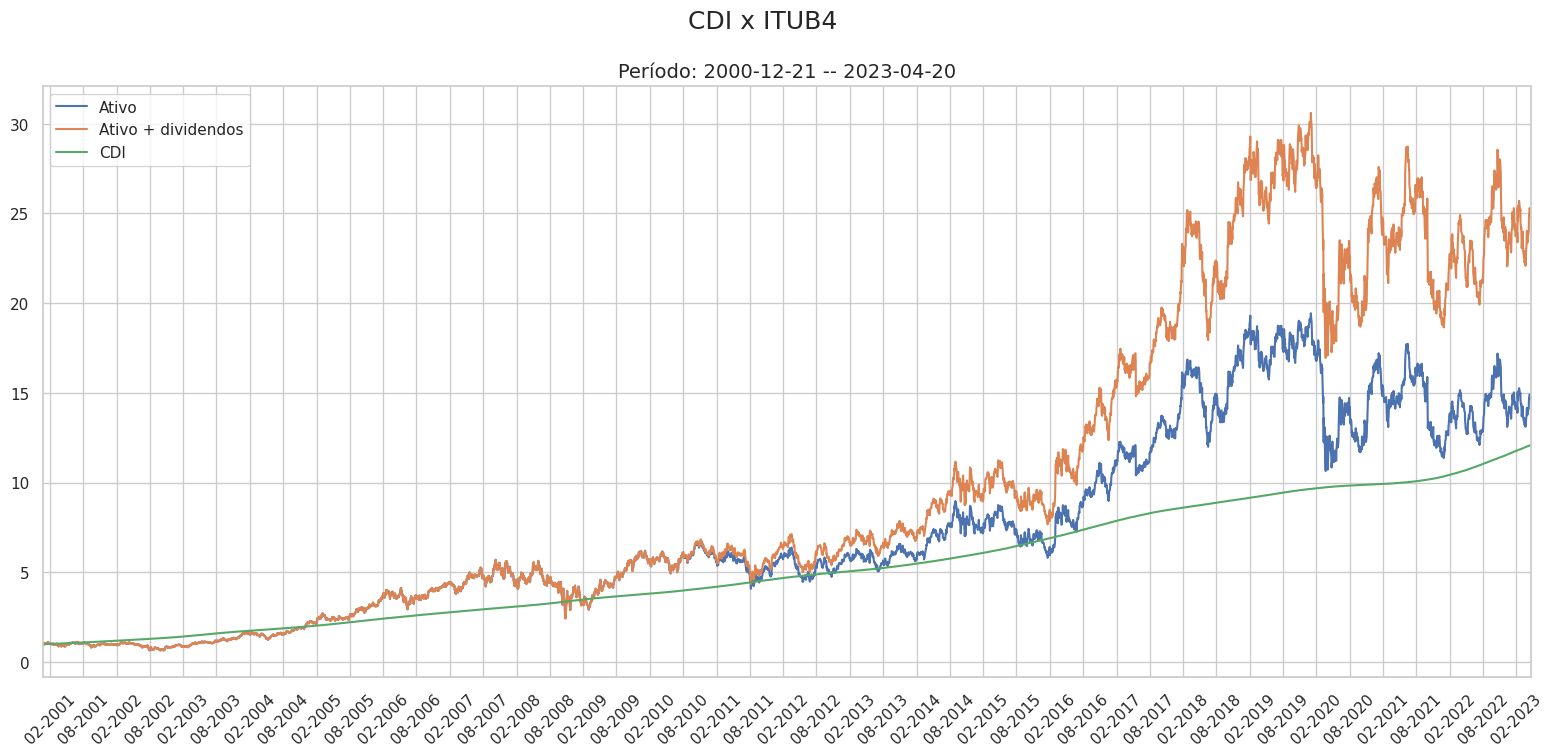

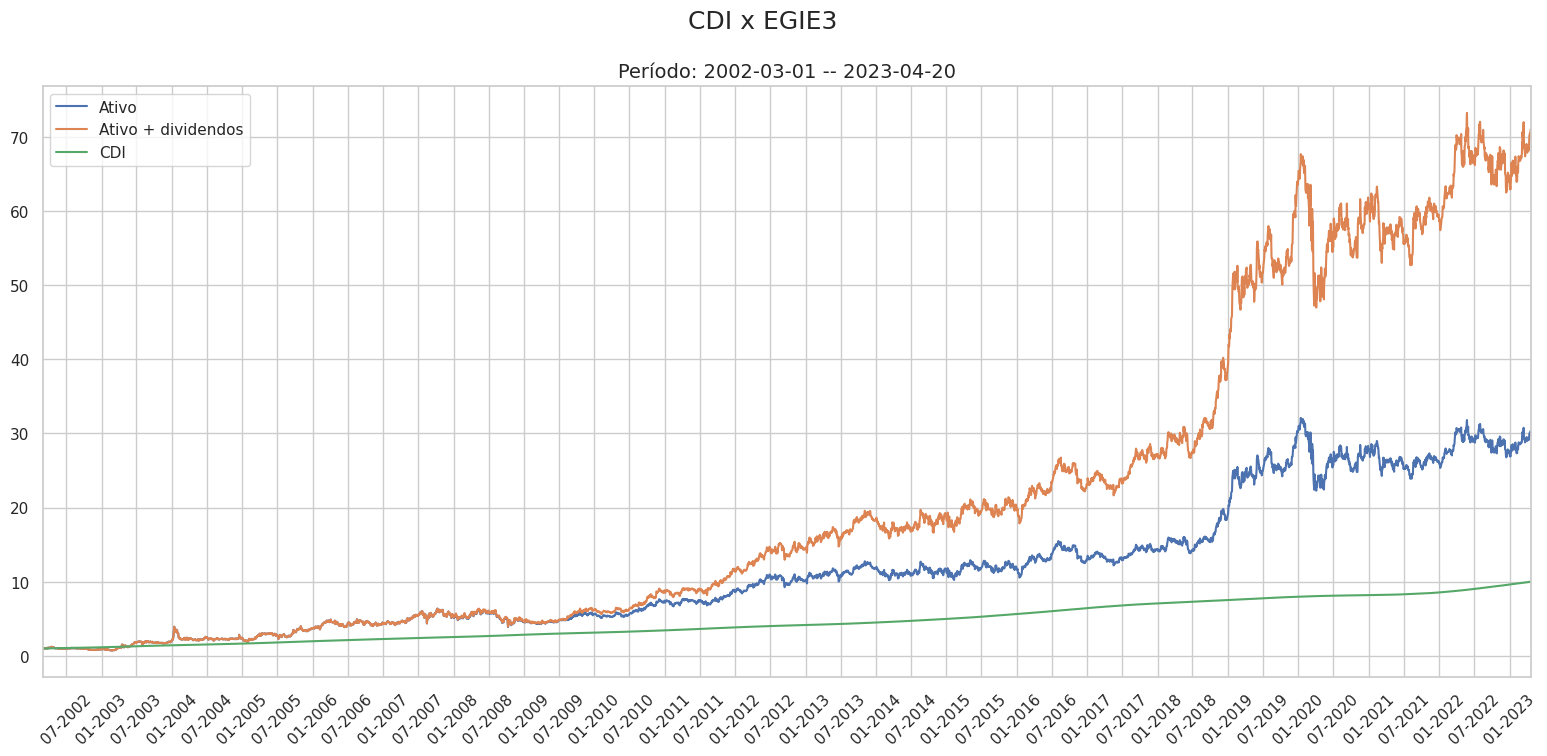

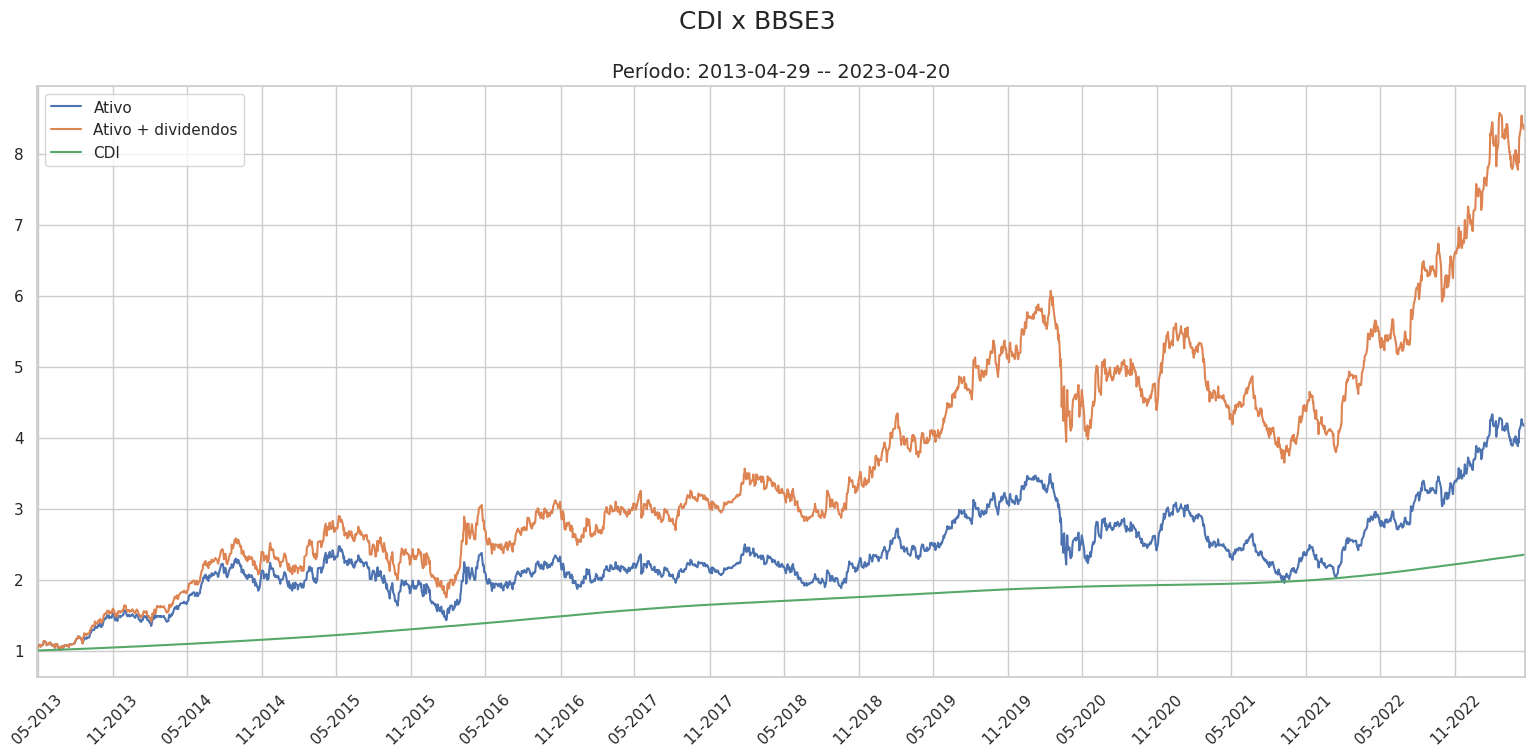

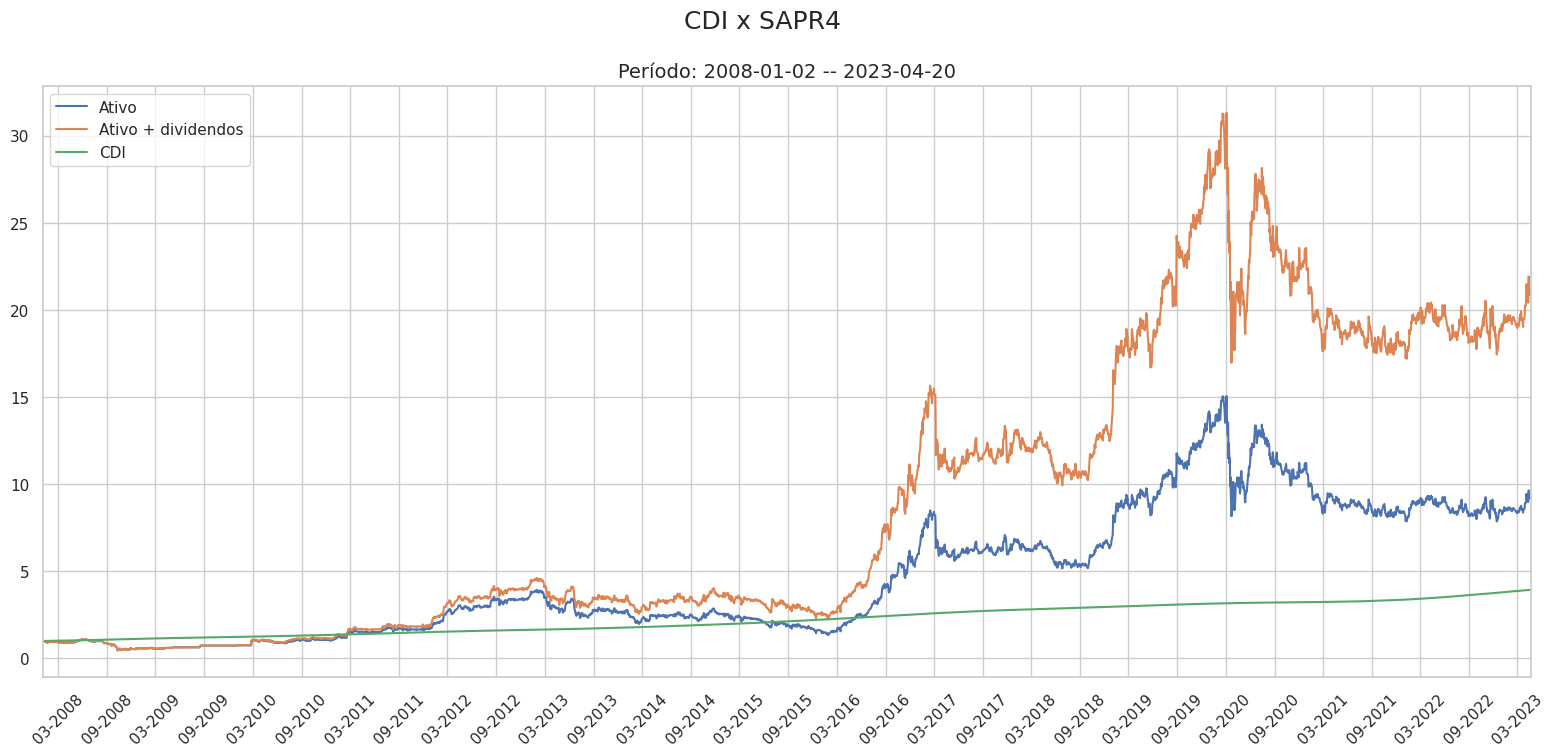

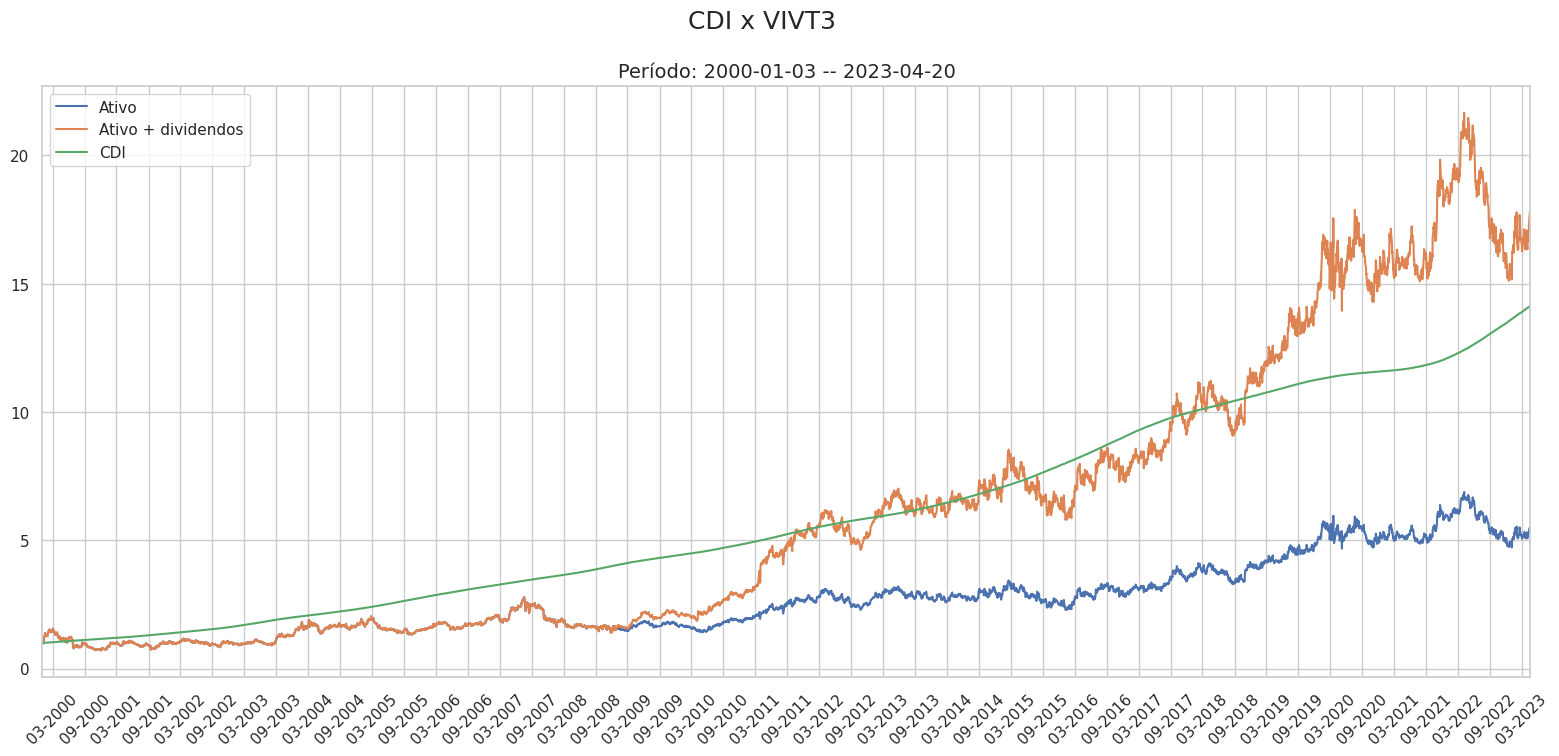

In [16]:
tempo = 30 # ALTERE O NÚMERO PARA O NÚMERO DE ANOS QUE QUER COMPARAR
graf_dividendos('ITUB4.SA' , tempo)
graf_dividendos('EGIE3.SA' , tempo)
graf_dividendos('BBSE3.SA', tempo)
graf_dividendos('SAPR4.SA', tempo)
graf_dividendos('VIVT3.SA' , tempo)